In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix
cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()

Porcentaje de operaciones con needs_m_check: 52.31 %
Porcentaje de operaciones con moderada: 67.80 %


,id_cr,id_fe,fe_cr_id,user_id,active,created_at,created_at_fe,amount,fee,stat_cr,...,needs_m_check_recov,n_fees,n_backs,n_recovery,n_incidents,GBP_EUR,BTC_GBP,inflation,unemploy_rate,moderada
0,3,0,NaN,47,1,1.574172e+09,NaN,1.0,0.0,8,...,1,6,0,0,1,1.16935,6347.577148,1.3,3.9,1


,id_cr,id_fe,fe_cr_id,user_id,active,created_at,created_at_fe,amount,fee,stat_cr,...,needs_m_check,n_fees,n_backs,n_recovery,n_incidents,GBP_EUR,BTC_GBP,inflation,unemploy_rate,moderada
0,-1.863397,-0.988067,0.0,-0.296422,0.295236,-4.502284,0.0,-3.185956,-1.38109,-0.497916,...,1.196949,3.682707,-1.047367,-0.41785,-0.327339,0.641888,-1.966732,2.324022,-2.926786,0.689217


Coeficientes del modelo de regresión logística (ordenados por magnitud):
stat_cr: -16.6542
recovery_status: -9.2944
stat_fe: -5.4178
fee: 1.8199
charge_moment: 0.8447
transfer_type: -0.4328
unemploy_rate: -0.2821
BTC_GBP: -0.2457
amount: -0.1667
inflation: -0.1522
GBP_EUR: -0.0363
user_id: 0.0332
created_at_dow: 0.0217
created_at_slot: 0.0118


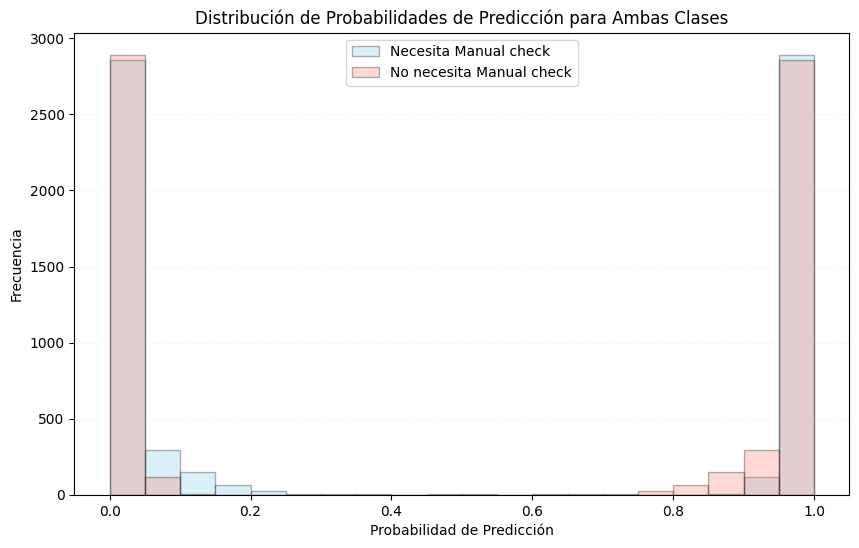

Coeficientes del modelo de regresión logística (ordenados por magnitud):
stat_cr: -16.6542
recovery_status: -9.2944
stat_fe: -5.4178
fee: 1.8199
charge_moment: 0.8447
transfer_type: -0.4328
unemploy_rate: -0.2821
BTC_GBP: -0.2457
amount: -0.1667
inflation: -0.1522
GBP_EUR: -0.0363
user_id: 0.0332
created_at_dow: 0.0217
created_at_slot: 0.0118


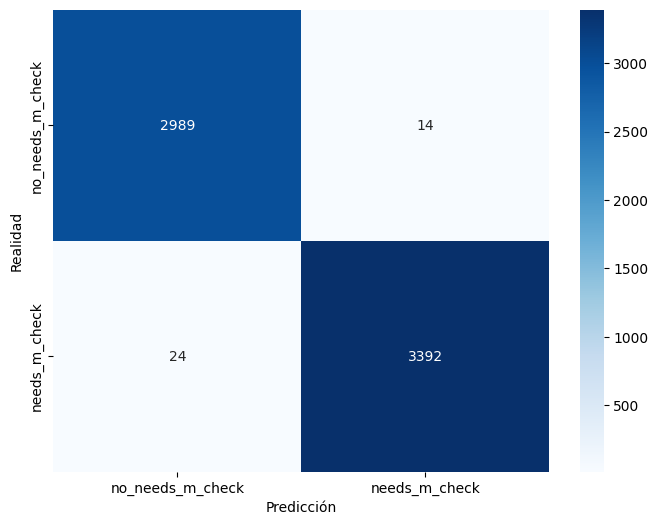

Accuracy: 0.9940800747780028
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99      3003
           1       1.00      0.99      0.99      3416

    accuracy                           0.99      6419
   macro avg       0.99      0.99      0.99      6419
weighted avg       0.99      0.99      0.99      6419



In [ ]:
df = df_jo.copy()
# Convertir columnas datetime a timestamps
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col] = df[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)
    
# Convertir columnas slot en enteros
df['created_at_slot'] = pd.to_numeric(df['created_at_slot'], errors='coerce').astype('Int64')
df['created_at_dow'] = pd.to_numeric(df['created_at_dow'], errors='coerce').astype('Int64')

df['moderada'] = df['moderated_at'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# Reasignar valores en la columna 'transfer_type' y 'charge_moment' para convertirlo a numéricas
#df = df.copy()
df['transfer_type'] = df['transfer_type'].map({'regular': 0, 'instant': 1})
df['charge_moment'] = df['charge_moment'].fillna('null').map({
    'before': 1,
    'after': 2,
    'null': 0  # Asigna 0 para los valores nulos llenados como 'null'
})
df['category'] = df['category'].fillna('null').map({'rejected': 1, 'month_delay_on_payment': 2, 'null':0})

# Descartar columna categorica
#df=df.drop(columns=['charge_moment'])

# Convertir timedelta a float en días
df['to_receive_ini'] = df['to_receive_ini'] / pd.Timedelta(days=1)
df['to_receive_bank'] = df['to_receive_bank'] / pd.Timedelta(days=1)
df['to_reimbur'] = df['to_reimbur'] / pd.Timedelta(days=1)
df['to_reimbur_cash'] = df['to_reimbur_cash'] / pd.Timedelta(days=1)
df['to_end'] = df['to_end'] / pd.Timedelta(days=1)
df['to_send'] = df['to_send'] / pd.Timedelta(days=1)

# Variable categorica type a numérica
df['type'] = df['type'].fillna('null').map({
    'instant_payment': 1,
    'split_payment': 2,    
    'incident': 3 ,
    'postpone' : 4,
    'null' : 0
})

# Variable categorica recovery_Status a numérica
df['recovery_status'] = df['recovery_status'].fillna('null').map({
    'completed': 1,
    'pending': 2,    
    'pending_direct_debit': 3 ,
    'null' : 0
})

# Variable categorica stat_cr a numérica
df['stat_cr'] = df['stat_cr'].fillna('null').map({
    'approved': 1,
    'money_sent': 2,    
    'rejected': 3 ,
    'pending': 4,
    'transaction_declined': 5,
    'waiting_user_information': 6,
    'direct_debit_rejected': 7,
    'canceled': 8,
    'direct_debit_sent': 9,
    'waiting_reimbursement': 10,
    'active': 11,
    'money_back': 12,    
    'null' : 0
})

# Variable categorica stat_fe a numérica
df['stat_fe'] = df['stat_fe'].fillna('null').map({
    'confirmed': 1,
    'rejected': 2,    
    'cancelled': 3 ,
    'accepted': 4,
    'null' : 0
})

# Descartar columnas repetidas
df=df.drop(columns=['created_at_d','created_at_slot_h','Mes_created_at'])
# Descartar columnas sin interés
df=df.drop(columns=['reason'])

# TODO 2024-12-09 Alba, Cesc: ejemplo para ver el balanceo de los datos ??
# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
#value_counts = df_simpl['needs_m_check_recov'].value_counts()
value_counts = df_jo['needs_m_check_recov'].value_counts()
# Calcular el total de operaciones (suma de las dos categorías)
total = value_counts[0] + value_counts[1]
# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
needs_manual = (value_counts[1] / total) * 100
# Imprimir el resultado
print(f'Porcentaje de operaciones con needs_m_check: {needs_manual:.2f} %')

# Obtener el conteo de los valores únicos en la columna 'needs_m_check_recov'
value_counts = df['moderada'].value_counts()
# Calcular el total de operaciones (suma de las dos categorías)
total = value_counts[0] + value_counts[1]
# Calcular el porcentaje de operaciones con 'needs_m_check' (cuando es 1)
moderadas = (value_counts[1] / total) * 100
# Imprimir el resultado
print(f'Porcentaje de operaciones con moderada: {moderadas:.2f} %')


display(df.head(1))
# Crear el escalador
scaler = StandardScaler()
needs=df['needs_m_check_recov']
df=df.drop(columns='needs_m_check_recov')
# Estandarizar todas las columnas
normalizado = scaler.fit_transform(df)
# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
df = pd.DataFrame(normalizado, columns=df.columns, index=df.index)
df.fillna(0, inplace=True)
display(df.head(1))
#df.info()

# Separación correcta de X e y
X = df[['user_id', 'stat_cr','stat_fe','amount','fee','recovery_status','GBP_EUR','inflation','BTC_GBP','unemploy_rate',
        'created_at_slot','created_at_dow','transfer_type','charge_moment']] # Elimina la columna objetivo
y = needs  # La columna de la variable objetivo

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de 
# optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")

# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.4f}")

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")
plt.show()
# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report   